In [3]:
import numpy as np
import scipy as sci
from typing import Iterator
import matplotlib.pyplot as plt

In [34]:
## define a function to simulate a data stream 
## with Gaussian distribution
def generate_gaussian_data_stream(mu, sigma, stream_size):
    return [data_point for data_point in np.random.normal(mu, sigma, stream_size)]

In [38]:
## define a class that uses reservoir sampling to 
## estimate the mean
class ReservoirSamplingEst:
    def __init__(self, k=20):
        # k (int) the size of the reservoir
        self.k = k
        self.reservoir = []
        self.est_mean = []
        
    def fit(self, data_stream):
        ## reservoir sampling
        for i, dp in enumerate(data_stream):
            if i < self.k:
                self.reservoir.append(dp)
            else:
                ## pick a data point uniformly at random from the reservoir
                idx = np.random.randint(0, self.k)
                ## replace the picked data point with prob. (k/i)
                if np.random.rand() < (self.k / i):
                    self.reservoir[idx] = dp
            
                ## estimate the mean
                est_m = np.mean(self.reservoir)
                self.est_mean.append(est_m)

In [71]:
## a simple baseline method 
## intuitively, we keep a local buffer of size k without any fancy sampling
## as data comes in we store them in the buffer as long as the size is within k
## we drop the earliest data point to maintain the size 
from collections import deque
class SlidingWindowBaseline:
    def __init__(self, k=20):
        self.k = k
        self.buffer = deque()
        self.est_mean = []

    def fit(self, data_stream):
        for i, dp in enumerate(data_stream):
            if i < self.k:
                self.buffer.append(dp)
            else:
                self.buffer.popleft()
                self.buffer.append(dp)

                ## estimate the mean based on the data in the buffer
                est_m = np.mean(self.buffer)
                self.est_mean.append(est_m)

In [81]:
## simulate a data stream with 100k data points
mu = 5.5
sigma = 3
N = 100000

## experiment with the size of k
RS_1000 = ReservoirSamplingEst(k=1000)
RS_5000 = ReservoirSamplingEst(k=5000)

baseline_1000 = SlidingWindowBaseline(k=1000)
baseline_5000 = SlidingWindowBaseline(k=5000)

data_stream = generate_gaussian_data_stream(mu, sigma, N)

RS_1000.fit(data_stream)
RS_5000.fit(data_stream)

baseline_1000.fit(data_stream)
baseline_5000.fit(data_stream)

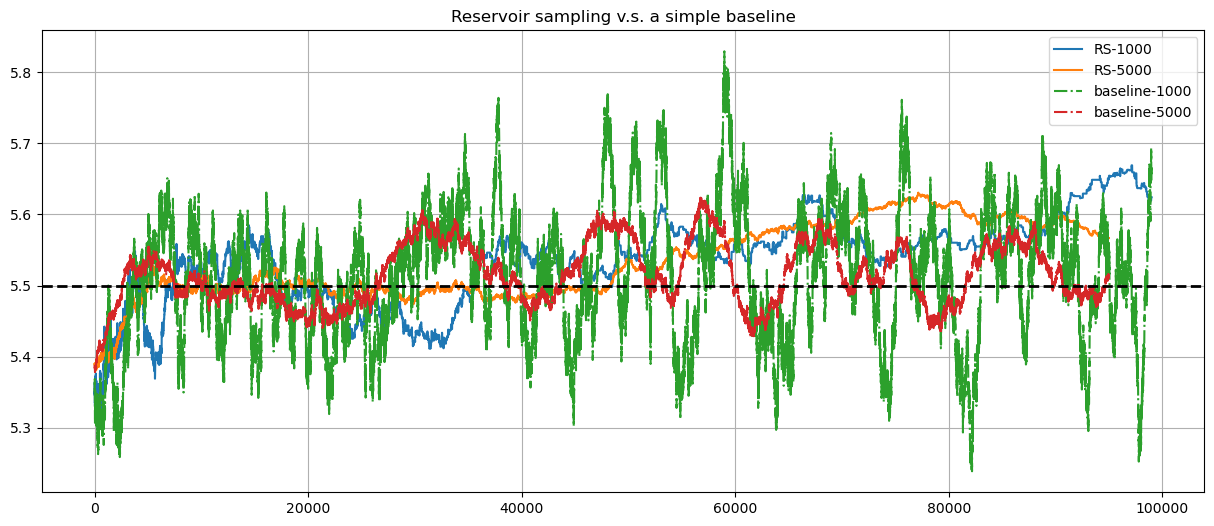

In [83]:
plt.figure(figsize=(15, 6))

plt.plot(RS_1000.est_mean, label='RS-1000')
plt.plot(RS_5000.est_mean, label='RS-5000')

plt.plot(baseline_1000.est_mean, label='baseline-1000', linestyle='-.')
plt.plot(baseline_5000.est_mean, label='baseline-5000', linestyle='-.')

plt.title("Reservoir sampling v.s. a simple baseline")
plt.axhline(y=mu, color='k', linestyle='--', linewidth=2)
plt.grid(True)
plt.legend()